# Object Detection Using SSD

Object detection detects instances of certain classes in digital images and videos (which can be regarded as sequences of images). In this notebook we demonstrate how to use pretrained Analytics Zoo model to detect objects in the video.

We used one of the videos in Youtube-8M ([link](https://research.google.com/youtube8m/)) for demo, which is a scene of training a dog. We use our SSD-MobileNet model (downloadable from [link](https://github.com/intel-analytics/analytics-zoo/blob/a43f9b5d1a94b29a2455f12109fe46995b16a8a9/docs/docs/models/objectdetection/README.md)) pretrained on PASCAL VOC dataset ([link](http://host.robots.ox.ac.uk/pascal/VOC/)) for detection. It is able to detect 20 classes including person and dog. In the video the dogs and persons are are identified with boxes and class scores are shown on top.
  
References: 
* YouTube-8M: A Large and Diverse Labeled Video Dataset for Video Understanding Research ([link](https://research.google.com/youtube8m/)).

## Intialization

* import necesary libraries

In [1]:
import os
from IPython.display import Image, display
%pylab inline
from moviepy.editor import *

Populating the interactive namespace from numpy and matplotlib


* import necessary modules

In [2]:
from zoo.common.nncontext import get_nncontext
from zoo.feature.image.imageset import *
from zoo.models.image.objectdetection.object_detector import *

* init SparkContext

In [3]:
sc = get_nncontext(create_spark_conf().setAppName("Object Detection Example"))

## Load pretrained Analytics Zoo model

* Here we use a SSD-MobileNet pretrained by PASCAL VOC dataset. 

Download [model](https://s3-ap-southeast-1.amazonaws.com/analytics-zoo-models/object-detection/analytics-zoo_ssd-mobilenet-300x300_PASCAL_0.1.0.model)

In [4]:
try:
    model_path = os.getenv("ANALYTICS_ZOO_HOME")+"/apps/object-detection/analytics-zoo_ssd-mobilenet-300x300_PASCAL_0.1.0.model"
    model = ObjectDetector.load_model(model_path)
    print("load model done")
except Exception as e:
    print("The pretrain model doesn't exist")
    print("you can run $ANALYTICS_ZOO_HOME/apps/object-detection/download_model.sh to download the pretrain model")

load model done


## Load data

* Load the video and get a short clip. Take this clip as a sequence of frames by given fps.

In [5]:
try:
    path = os.getenv("ANALYTICS_ZOO_HOME")+"/apps/object-detection/train_dog.mp4"
    myclip = VideoFileClip(path).subclip(8,18)
except Exception as e:
    print("The video doesn't exist.")
    print("Please prepare the video first.")

video_rdd = sc.parallelize(myclip.iter_frames(fps=5))
image_set = DistributedImageSet(video_rdd)

creating: createDistributedImageSet


## Predict and visualize detection back to clips

* Having prepared the model, we can start detecting objects. 

Read the image as ImageSet(local/distributed) -> Perform prediction -> Visualize the detections in original images

In [6]:
output = model.predict_image_set(image_set)

config = model.get_config()
visualizer = Visualizer(config.label_map())
visualized = visualizer(output).get_image(to_chw=False).collect()

creating: createVisualizer


## Save clips to file

* Make sequence of frames back to a clip by given fps.

In [7]:
clip = ImageSequenceClip(visualized, fps=5)

output_path = '/tmp/out.mp4'
clip.write_videofile(output_path, audio=False)
clip.write_gif("train_dog.gif")

[MoviePy] >>>> Building video /tmp/out.mp4
[MoviePy] Writing video /tmp/out.mp4


100%|██████████| 50/50 [00:00<00:00, 734.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /tmp/out.mp4 


[MoviePy] Building file train_dog.gif with imageio


100%|██████████| 50/50 [00:02<00:00, 18.74it/s]


## Display Object Detection Video 

* Display the prediction of the model.

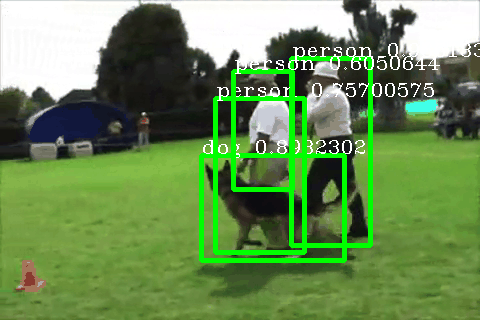

In [8]:
with open("train_dog.gif",'rb') as f:
    display(Image(f.read()))